# Web Analytics Demo

## Import Required Libraries

In [1]:
# Data Creation and Manipulation
import pandas as pd
import numpy as np
from pandasql import sqldf  # !pip install pandasql if needed

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats

## Net New Email Subscribes

1. Import our email subscription data
1. Create a new feature "net_new_subscribers"
1. Total net new suscribers and visualize

In [21]:
df = pd.read_csv("email-subscribes.csv")

In [22]:
df['net_new_subscribers'] = df['subscribe'] - df['unsubscribe']

In [23]:
df.head()

,date,subscribe,unsubscribe,net_new_subscribers
0,1/1/2021,37,3,34
1,1/2/2021,53,4,49
2,1/3/2021,53,3,50
3,1/4/2021,50,4,46
4,1/5/2021,51,1,50


In [24]:
df['net_new_subscribers'].sum()

2867

<AxesSubplot:>

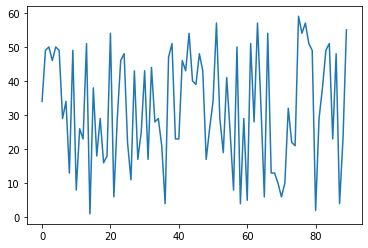

In [25]:
df['net_new_subscribers'].plot(kind='line')

## Cost per Click

Compare daily average cost per click for 2 different ad keywords to see if one keyword is significantly more expensive than another.

1. Create data
1. Visualize
1. Run statistical test to determine significance

In [2]:
# Compare daily average cost per click for 2 different ad keywords

# Create normally distributed sample data to compare
avg, st_dev = .85, 0.1 # mean and standard deviation
keyword_1 = np.random.normal(avg, st_dev, 1000)

avg, st_dev = .95, 0.15
keyword_2 = np.random.normal(avg, st_dev, 1000)

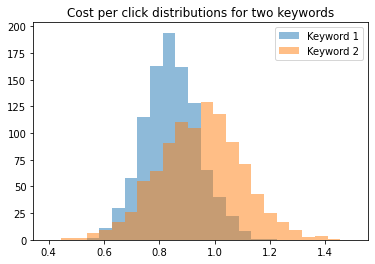

In [3]:
# Create visualization
bins = np.linspace(start=0.4, stop=1.5, num=25)

plt.hist(keyword_1, bins, alpha=0.5, label='Keyword 1')
plt.hist(keyword_2, bins, alpha=0.5, label='Keyword 2')
plt.legend(loc='upper right')
plt.title("Cost per click distributions for two keywords")
plt.show()

In [55]:
test_statistic, p_value = stats.ttest_ind(keyword_1,
                                          keyword_2,
                                          equal_var=False)

Before we actually look at the result, we need to decide on our p-value that we will use to determine whether the results are significant.

These are p-values you can use based on your sample size.

| Sample Size |
|-------------|

|  | 30 | 50 | 100 | 1000 |
|------|--------|------|------|--------|
| Weak | 0.076 | 0.053 | 0.032 | 0.009 |
| Fair | 0.028 | 0.019 | 0.010 | 0.003 |
| Strong | 0.005 | 0.003 | 0.001 | 0.0003 |
| Very Strong | 0.001 | 0.0005 | 0.0001 | 0.00004 |

In [58]:
p_value

4.4980095573753844e-55

Whoa, that's tiny!

From this, we can see that the average cost per click of the two keywords is significantly different. We might consider recommending that the less expensive keyword receive a greater amount of the budget if it also performs better in terms of conversions.

## Add-to-Carts

1. Import [ecom data](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store?select=2019-Oct.csv)
1. Count the add-to-cart events
1. Break down by subcategories (e.g., brand, location, etc.)

In [66]:
import_columns = ['event_type', 'brand', 'product_id', 'user_id', 'user_session']

df = pd.read_csv('C:/Users/ericd/Desktop/ecom-data.csv',
                 usecols=import_columns)

In [67]:
add_to_carts = len(df[df['event_type'] == "cart"])
print(f"There are {add_to_carts} add-to-cart events in the dataset.")

There are 926516 add-to-cart events in the dataset.


In [68]:
df.head()

,event_type,product_id,brand,user_id,user_session
0,view,44600062,shiseido,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,view,3900821,aqua,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,view,17200506,NaN,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,view,1307067,lenovo,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,view,1004237,apple,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


Now we can look at add-to-cart events by brand to see which brands are the most popular.

In [84]:
# Create dataframe grouping add-to-carts by brand
brand_df = ((df[df['event_type'] == "cart"]
            .groupby('brand')
            .agg(add_to_carts = pd.NamedAgg(column = 'event_type', aggfunc='count')))
            .sort_values(by=['add_to_carts'], ascending=False))

<AxesSubplot:xlabel='brand'>

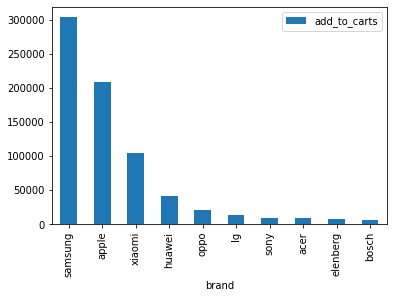

In [88]:
# Quick bar plot to see if there's anything interesting!
brand_df.head(10).plot(kind='bar')

## Conversion Rate
This is just a quick calculation. We are looking at the number of sessions where a purchase was made divided by the total number of unique sessions.

1. Create total sessions and sessions with purchase variables
2. Divide purchase into total to get conversion rate

In [132]:
total_sessions = df['user_session'].nunique()
purchase_sessions = df[df['event_type'] == "purchase"]['user_session'].nunique()

conversion_rate = purchase_sessions / total_sessions

In [133]:
print(f"Conversion Rate: {round(conversion_rate*100, 1)}%")

Conversion Rate: 6.8%


## Average Order Value (AOV)

1. Import [Olist data](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_payments_dataset.csv). In this case, we are using multiple datasets and joining them with SQL.
1. Calculate overall AOV from payments dataset
1. Join all datasets to subset AOV by different subcategories (e.g., city, state)

In [107]:
payments_df = pd.read_csv("C:/Users/ericd/Desktop/olist_order_payments.csv", 
                          usecols=['order_id', 'payment_type', 'payment_value'])

orders_df = pd.read_csv("C:/Users/ericd/Desktop/olist_orders.csv", 
                        usecols=['order_id', 'customer_id'])

customers_df = pd.read_csv("C:/Users/ericd/Desktop/olist_customers.csv", 
                           usecols=['customer_id', 'customer_city', 'customer_state'])

In [127]:
payments_df.head()

,order_id,payment_type,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,99.33


In [118]:
# This is the "vanilla" Average Order Value (AOV)
payments_df['payment_value'].mean()

154.10038041698365

### Joining Tables for Deeper Analysis

We can join related tables together to give us new data to work with. Here, we will use SQL.

In [ ]:
payments_df.head(1)

In [113]:
orders_df.head(1)

,order_id,customer_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d


In [112]:
customers_df.head(1)

,customer_id,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP


In [ ]:
query = '''
        SELECT c.customer_state,
               AVG(p.payment_value) as avg_order_value
        FROM payments_df p
        JOIN orders_df o
            ON o.order_id = p.order_id
        JOIN customers_df c
            ON c.customer_id = o.customer_id
        GROUP BY c.customer_state
        ORDER BY AVG(p.payment_value) DESC
'''

print(sqldf(query))

How many orders are from each state? That could have an impact on the average order value.

In [ ]:
# Adding the count of orders to the query
query = '''
        SELECT c.customer_state,
               AVG(p.payment_value) as avg_order_value,
               COUNT(p.order_id) as number_of_orders
        FROM payments_df p
        JOIN orders_df o
            ON o.order_id = p.order_id
        JOIN customers_df c
            ON c.customer_id = o.customer_id
        GROUP BY c.customer_state
        -- ORDER BY AVG(p.payment_value) DESC
        ORDER BY COUNT(p.order_id) DESC
'''

print(sqldf(query))

In [136]:
# You can save your query results to a dataframe for further analysis
aov_df = sqldf(query)

In [ ]:
aov_df

## Bonus: 5 Project Ideas
The datasets today are great sources of projects. Google Analytics also has free e-Commerce data available for the Google official merchandise store. To set up an account, click [here](https://support.google.com/analytics/answer/6367342?hl=en). It only takes about 30 seconds to set up.

Once you've got that set up, try these projects:

1. Use [ecom data](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store?select=2019-Oct.csv) from the add-to-cart section above to see which specific products are added to cart most often.
1. Use [full Olist ecom dataset](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_payments_dataset.csv) from the AOV section above to calculate average delivery times for each state. There may be certain locations that are experiencing long wait times for products.
1. Identify top performing keywords by number of clicks and by cost. Make recommendations regarding specific keywords or ad campaigns that should receive more budget or be discontinued.
1. Calculate cost per conversion for Q1 2021 (Jan-Apr) and find the products that were involved in the most conversions.
1. Analyze the bounce rate for the top 10 webpages on the site. Make recommendations regarding A/B tests that could be conducted to reduce the bounce rate and retain traffic.